### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Transformers

#### Self-attention

**Idea of self-attention**

It’s a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should “pay more attention” to some features and “pay less attention” to other features.

Does that sound familiar? You’ve already encountered a similar concept twice in this book:
- Max pooling in convnets looks at a pool of features in a spatial region and selects just one feature to keep. That’s an “all or nothing” form of attention: keep the most important feature and discard the rest.
- TF-IDF normalization assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted while irrelevant tokens get faded out. That’s a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones. How these scores should be computed, and what you should do with them, will vary from approach to approach.

**Why self-attention required**

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. 

You’ve just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. 

In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that’s not quite how language works: the meaning of a word is usually context-specific. 

When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. 

When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” 

And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

**What exactly is self-attention - In Short**

Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That’s where self-attention comes in. 

The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations.

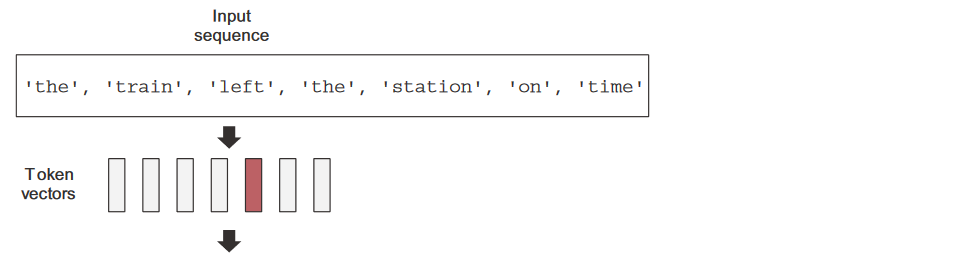

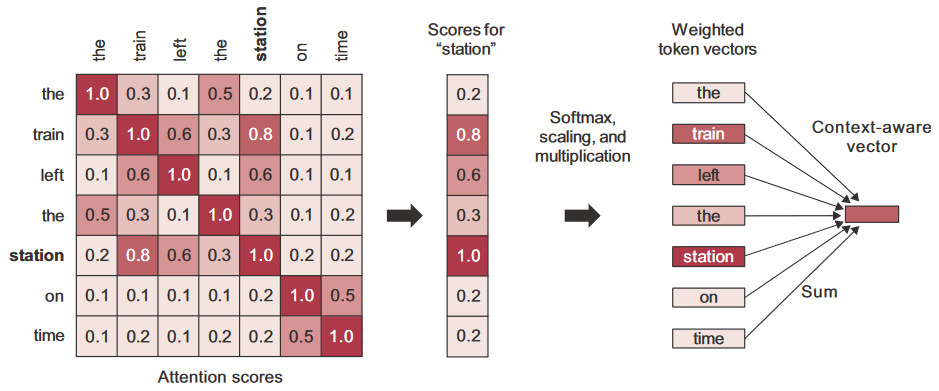

**How to calculate - A Simplified View**

> Step 1

Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. 

These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. 

It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. 

In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.

> Step 2

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. 

Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. 

The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

**Implementation**

```
def self_attention(input_sequence):
    # Initializing the output matrix as the same shape as input_sequence (list of embedding vectors corresponding to the words in the sequence)  
    output = np.zeros(shape=input_sequence.shape)

    # Iterate over each token in the input sequence
    for i, pivot_vector in enumerate(input_sequence):
        # Initializing the score vector (1D - 1 score element for each token)
        scores = np.zeros(shape=(len(input_sequence),))
        # Iterate over each token in the input sequence
        for j, vector in enumerate(input_sequence):
            # Calculating dot product(similarity) between pivot_vector and all the other vectors in the sequence
            # Storing the scores in the list 
            scores[j] = np.dot(pivot_vector, vector.T)
        # Scale by a normalization factor, and apply a softmax
        scores /= np.sqrt(input_sequence.shape[1])
        scores = softmax(scores)
        # Initializing a matrix of the same shape as pivot_vector so that we can store the new representation of the pivot vector calculated similarity scores of other tokens around it  
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            # Take the sum of all tokens weighted by the attention scores
            new_pivot_representation += vector * scores[j]
        # Storing the new final representation of the pivot vector in the proper index as per its position in the input_sequence
        output[i] = new_pivot_representation
    return output
```

In practice you’d use a vectorized implementation. Keras has a built-in layer to handle it: the MultiHeadAttention layer.

```
num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)
```

**Things to understand here**

- Why are we passing the inputs to the layer three times? That seems redundant.
- What are these “multiple heads” we’re referring to? That sounds intimidating-do they also grow back if you cut them?